# LQR Control Derivation

## Dynamic Bicycle Model in Error Frame

[See here](http://localhost:8888/notebooks/dynamics/docs/VehicleMotionModel.ipynb) for derivation of dynamic bicycle model

<img src="dynamic_model_error_frame.png" align="left" width="900"/> 

## LQR Feedback/Feedforward Derivation

<img src="lqr_tracker.png" align="left" width="700"/> 

# Example - Step E1/E2 Regulation

In [1]:
%matplotlib notebook

from dynamics.kinematic_model import CartesianKinematicBicycleModel, MotionModel
from dynamics.CartesianDynamicBicycleModel import CartesianDynamicBicycleModel
from dynamics.Vehicle import Vehicle

from control.lqr_path_tracker import DynamicLQRPathTracker, LQRPathTrackerBase, KinematicLQRPathTracker

from paths.straight_path import StraightPath

from utils import math

import numpy as np
import matplotlib.pyplot as plt

pygame 2.3.0 (SDL 2.24.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


iter: 150
iter: 150
iter: 150
iter: 150
iter: 150
iter: 150
iter: 150
iter: 150
iter: 150
iter: 150


<IPython.core.display.Javascript object>


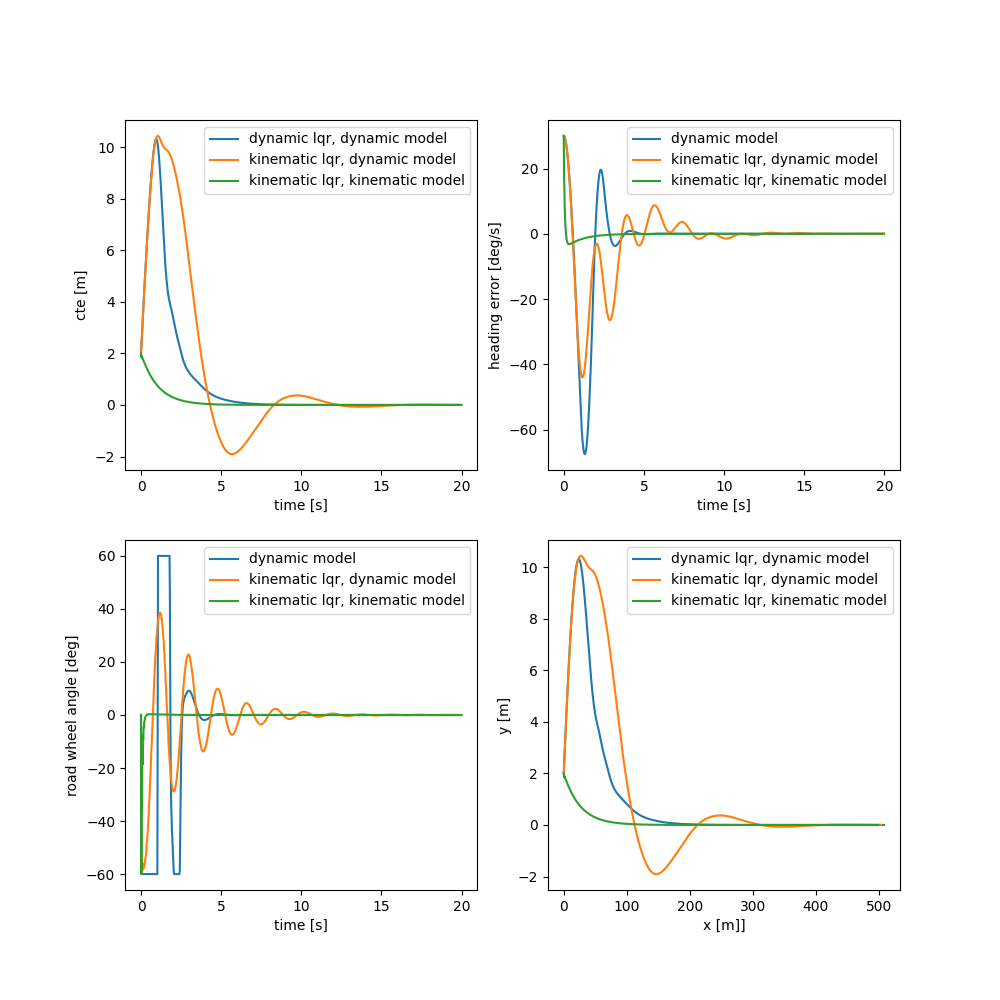

In [2]:
vel_mps = 25
dt = 0.02
t_final = 20

cte_init = 2.0
heading_error_init_deg = 30

# init lqr controls
Q=np.zeros((4,4))
Q[0,0] = 1
lqr_params = LQRPathTrackerBase.Params(Q=np.identity(4), R=np.array([[1]]), dt=dt)
dynamic_lqr = DynamicLQRPathTracker(lqr_params)
kinematic_lqr = KinematicLQRPathTracker(lqr_params)

# init straight path
straight_path = StraightPath()

# init motion models
kinematic_model = CartesianKinematicBicycleModel(MotionModel.IntScheme.RK4)
dynamic_model = CartesianDynamicBicycleModel(MotionModel.IntScheme.RK4)

# init vehicle
car_params = Vehicle.Params()
car_params.cr = 2e4
car_params.cf = 2e4
vehicle_state_init = Vehicle(params=car_params).build_pose(math.Pose(x=0,y=cte_init,theta=np.deg2rad(heading_error_init_deg))).build_vel(vel=vel_mps, beta=0)

t_array = np.arange(start=0, stop=t_final, step=dt)
dyn_model_dyn_lqr_states = [vehicle_state_init]
dyn_model_kin_lqr_states = [vehicle_state_init]
kin_model_kin_lqr_states = [vehicle_state_init]

for idx in range(len(t_array)-1):
    curr_state = dyn_model_dyn_lqr_states[-1]
    steer_angle_cmnd = dynamic_lqr.update(curr_state, straight_path)
    next_state = dynamic_model.update(curr_state, steer=steer_angle_cmnd, vel=vel_mps, dt=dt)
    dyn_model_dyn_lqr_states.append(next_state)
    
    curr_state = dyn_model_kin_lqr_states[-1]
    steer_angle_cmnd = kinematic_lqr.update(curr_state, straight_path)
    next_state = dynamic_model.update(curr_state, steer=steer_angle_cmnd, vel=vel_mps, dt=dt)
    dyn_model_kin_lqr_states.append(next_state)
    
    curr_state = kin_model_kin_lqr_states[-1]
    steer_angle_cmnd = kinematic_lqr.update(curr_state, straight_path)
    next_state = kinematic_model.update(curr_state, steer=steer_angle_cmnd, vel=vel_mps, dt=dt)
    kin_model_kin_lqr_states.append(next_state)
    
    
# plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs = axs.flatten()
idx_axs = 0
axs[idx_axs].plot(t_array, [z.pose.y for z in dyn_model_dyn_lqr_states], label="dynamic lqr, dynamic model")
axs[idx_axs].plot(t_array, [z.pose.y for z in dyn_model_kin_lqr_states], label="kinematic lqr, dynamic model")
axs[idx_axs].plot(t_array, [z.pose.y for z in kin_model_kin_lqr_states], label="kinematic lqr, kinematic model")
axs[idx_axs].set_xlabel("time [s]")
axs[idx_axs].set_ylabel("cte [m]")
axs[idx_axs].legend();

idx_axs += 1
axs[idx_axs].plot(t_array, [np.rad2deg(z.pose.theta) for z in dyn_model_dyn_lqr_states], label="dynamic model")
axs[idx_axs].plot(t_array, [np.rad2deg(z.pose.theta) for z in dyn_model_kin_lqr_states], label="kinematic lqr, dynamic model")
axs[idx_axs].plot(t_array, [np.rad2deg(z.pose.theta) for z in kin_model_kin_lqr_states], label="kinematic lqr, kinematic model")
axs[idx_axs].set_xlabel("time [s]")
axs[idx_axs].set_ylabel("heading error [deg/s]")
axs[idx_axs].legend();

idx_axs += 1
axs[idx_axs].plot(t_array, [np.rad2deg(z.state_cog.delta) for z in dyn_model_dyn_lqr_states], label="dynamic model")
axs[idx_axs].plot(t_array, [np.rad2deg(z.state_cog.delta) for z in dyn_model_kin_lqr_states], label="kinematic lqr, dynamic model")
axs[idx_axs].plot(t_array, [np.rad2deg(z.state_cog.delta) for z in kin_model_kin_lqr_states], label="kinematic lqr, kinematic model")
axs[idx_axs].set_xlabel("time [s]")
axs[idx_axs].set_ylabel("road wheel angle [deg]")
axs[idx_axs].legend();

idx_axs +=1
axs[idx_axs].plot([z.pose.x for z in dyn_model_dyn_lqr_states], [z.pose.y for z in dyn_model_dyn_lqr_states], label="dynamic lqr, dynamic model")
axs[idx_axs].plot([z.pose.x for z in dyn_model_kin_lqr_states], [z.pose.y for z in dyn_model_kin_lqr_states], label="kinematic lqr, dynamic model")
axs[idx_axs].plot([z.pose.x for z in kin_model_kin_lqr_states], [z.pose.y for z in kin_model_kin_lqr_states], label="kinematic lqr, kinematic model")
axs[idx_axs].set_xlabel("x [m]]")
axs[idx_axs].set_ylabel("y [m]")
axs[idx_axs].legend();

plt.show()